<a href="https://colab.research.google.com/github/aabs7/CNN-denoiser/blob/master/Code/Denoising/Speech_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import librosa
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import IPython.display as ipd
import librosa.display
import scipy
import glob
import os
import datetime
import librosa.display

# load the tensorboard notebook extension
%load_ext tensorboard

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7493795172067091141, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11344216064
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16193825841204983995
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
tf.random.set_seed(999)
np.random.seed(999)

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
! ls /content/drive/MyDrive/Dataset/records/

test_0.tfrecords   train_1.tfrecords  train_5.tfrecords  val_1.tfrecords
test_1.tfrecords   train_2.tfrecords  train_6.tfrecords  val_2.tfrecords
test_2.tfrecords   train_3.tfrecords  train_7.tfrecords  val_3.tfrecords
train_0.tfrecords  train_4.tfrecords  val_0.tfrecords


In [6]:
path_to_dataset = "/content/drive/MyDrive/Dataset/records/"

In [12]:
# get training and validation tf record file names
train_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset,'train_*'))
val_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset,'val_*'))

# shuffle the file names for training
np.random.shuffle(train_tfrecords_filenames)
print("Training file names:",train_tfrecords_filenames)
print("Validation file names:", val_tfrecords_filenames)

Training file names: ['/content/drive/MyDrive/Dataset/records/train_3.tfrecords', '/content/drive/MyDrive/Dataset/records/train_2.tfrecords', '/content/drive/MyDrive/Dataset/records/train_6.tfrecords', '/content/drive/MyDrive/Dataset/records/train_7.tfrecords', '/content/drive/MyDrive/Dataset/records/train_1.tfrecords', '/content/drive/MyDrive/Dataset/records/train_5.tfrecords', '/content/drive/MyDrive/Dataset/records/train_4.tfrecords', '/content/drive/MyDrive/Dataset/records/train_0.tfrecords']
Validation file names: ['/content/drive/MyDrive/Dataset/records/val_0.tfrecords', '/content/drive/MyDrive/Dataset/records/val_1.tfrecords', '/content/drive/MyDrive/Dataset/records/val_2.tfrecords', '/content/drive/MyDrive/Dataset/records/val_3.tfrecords']


In [13]:
# Parameters about window and audio
windowLength = 256
overlap = round(0.25 * windowLength) #overlap of 75%
fftLength = windowLength
inputFs = 48e3
fs = 16e3
numFeatures = fftLength//2 + 1
numSegments = 8
print("windowLength:",windowLength)
print("overlap:",overlap)
print("ffTLength:",fftLength)
print("inputFs:",inputFs)
print("fs:",fs)
print("numFeatures:",numFeatures)
print("numSegments:",numSegments)

windowLength: 256
overlap: 64
ffTLength: 256
inputFs: 48000.0
fs: 16000.0
numFeatures: 129
numSegments: 8


In [14]:
def tf_record_parser(record):
    keys_to_features = {
        "noise_stft_phase": tf.io.FixedLenFeature((),tf.string,default_value = ""),
        "noise_stft_mag_features": tf.io.FixedLenFeature([],tf.string),
        "clean_stft_magnitude": tf.io.FixedLenFeature((),tf.string)
    }
    
    features = tf.io.parse_single_example(record,keys_to_features)
    
    noise_stft_mag_features = tf.io.decode_raw(features['noise_stft_mag_features'],tf.float32)
    clean_stft_magnitude = tf.io.decode_raw(features['clean_stft_magnitude'],tf.float32)
    noise_stft_phase = tf.io.decode_raw(features['noise_stft_phase'],tf.float32)
    
    # reshape input and annotation images
    noise_stft_mag_features = tf.reshape(noise_stft_mag_features,(129,8,1),name = "noise_stft_mag_features")
    clean_stft_magnitude = tf.reshape(clean_stft_magnitude,(129,1,1),name = "clean_stft_magnitude")
    noise_stft_phase = tf.reshape(noise_stft_phase,(129,),name = "noise_stft_phase")
    
    return noise_stft_mag_features,clean_stft_magnitude

In [15]:
train_dataset = tf.data.TFRecordDataset([train_tfrecords_filenames])
train_dataset = train_dataset.map(tf_record_parser)
train_dataset = train_dataset.shuffle(buffer_size = 50)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [16]:
# explore dataset
print(train_dataset.take(1))

<TakeDataset shapes: ((None, 129, 8, 1), (None, 129, 1, 1)), types: (tf.float32, tf.float32)>


In [17]:
test_dataset = tf.data.TFRecordDataset([val_tfrecords_filenames])
test_dataset = test_dataset.map(tf_record_parser)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(32)

# Model Training

In [18]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras import Model, Sequential

In [19]:
def build_model(l2_strength):
    inputs = Input(shape = [numFeatures,numSegments,1])
    x = inputs
    x = tf.keras.layers.ZeroPadding2D(((4,4),(0,0)))(x)
    
    # 1. -----------------------------------------------------------
    
    x = Conv2D(name = "I.Conv",
              filters = 18,
              kernel_size = [9,8],
              strides = [1,1],
              padding = 'valid',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    skip0 = Conv2D(name = "II.Conv.S",
                   filters = 30,
                   kernel_size = [5,1],
                   strides = [1,1],
                   padding = 'same',
                   use_bias = False,
                   kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
                  )(x)
    x = Activation('relu')(skip0)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "III.Conv",
              filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # 2. ----------------------------------------------------------
    
    x = Conv2D(name = "IV.Conv",
              filters = 18,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    skip1 = Conv2D(name = "V.Conv.S",
                   filters = 30,
                   kernel_size = [5,1],
                   strides = [1,1],
                   padding = 'same',
                   use_bias = False,
                   kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
                  )(x)
    x = Activation('relu')(skip1)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "VI.Conv",
              filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # 3. ----------------------------------------------------------
    
    x = Conv2D(name = "VII.Conv",
              filters = 18,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "VIII.Conv",
              filters = 30,
              kernel_size = [5,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "IX.Conv",
              filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # 4. ----------------------------------------------------------
    
    x = Conv2D(name = "X.Conv",
              filters = 18,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "XI.Conv.ADD.V.Conv",
              filters = 30,
              kernel_size = [5,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    
    x = x + skip1
    
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "XII.Conv",
              filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    # 5. ----------------------------------------------------------
    
    x = Conv2D(name = "XIII.Conv",
              filters = 18,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "XIV.Conv.ADD.II.Conv",
              filters = 30,
              kernel_size = [5,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    
    x = x + skip0
    
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(name = "XV.Conv",
              filters = 8,
              kernel_size = [9,1],
              strides = [1,1],
              padding = 'same',
              use_bias = False,
              kernel_regularizer = tf.keras.regularizers.l2(l2_strength)
              )(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    
    #----------------------------------------------------------
    
    
    x = tf.keras.layers.SpatialDropout2D(0.2)(x)
    x = Conv2D(name = "XVI.Conv",
               filters = 1,
               kernel_size = [129,1],
               strides = [1,1],
               padding = 'same'
              )(x)
    
    model = Model(inputs = inputs, outputs = x)
    
    optimizer = tf.keras.optimizers.Adam(3e-4)
    
    model.compile(optimizer = optimizer,
                  loss = 'mse',
                  metrics = [tf.keras.metrics.RootMeanSquaredError('rmse')]
                 )
    
    return model   

In [ ]:
model = build_model(l2_strength = 0.0)
model.summary()

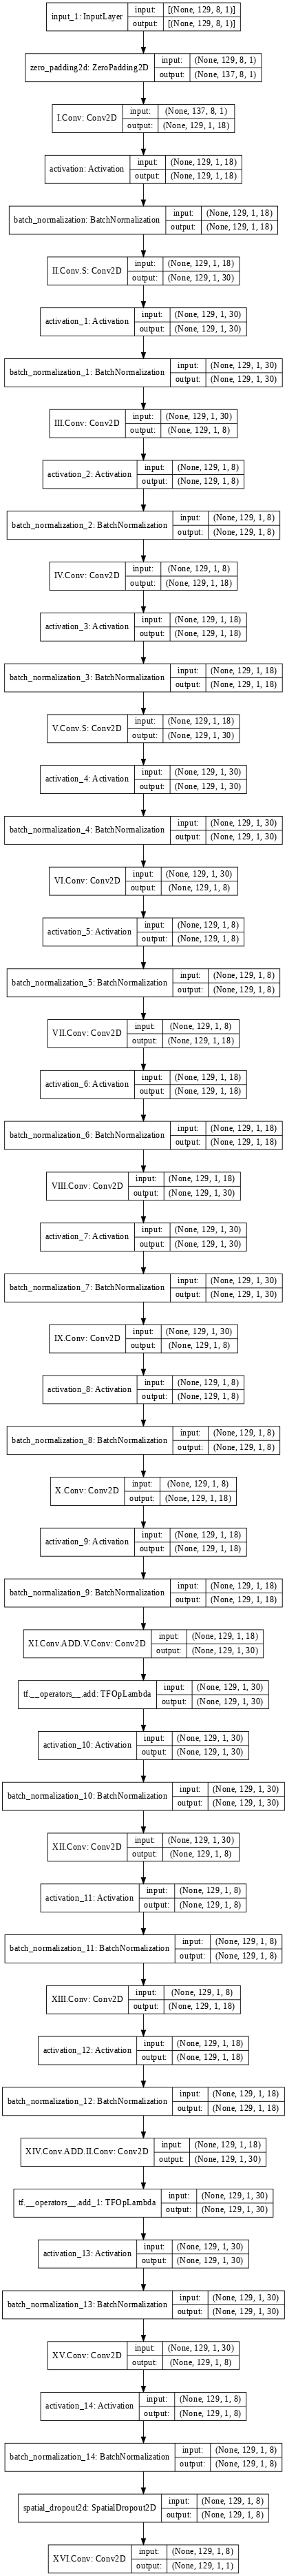

In [21]:
tf.keras.utils.plot_model(model,show_shapes = True,dpi = 64)

In [ ]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 388), started 0:14:45 ago. (Use '!kill 388' to kill it.)

<IPython.core.display.Javascript object>

In [22]:
def l2_norm(vector):
    return np.square(vector)

def SDR(denoised,cleaned,eps = 1e-7):
    a = l2_norm(denoised)
    b = l2_norm(denoised - cleaned)
    a_b = a / b
    return np.mean(10 * np.log10(a_b + eps))

In [ ]:
!ls ./

'"'   drive   logs   model.png	 sample_data


In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                          patience = 50,
                                                          restore_best_weights = True,
                                                          baseline = None)
logdir = os.path.join("logs",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir,update_freq = 'batch')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/Dataset/denoiser_cnn_log_mel_generator.h5',
                                                        monitor = 'val_loss',
                                                        save_best_only = True)

model.fit(train_dataset,
         steps_per_epoch = 50,
         validation_data = test_dataset,
         epochs = 1032,
         callbacks = [early_stopping_callback,tensorboard_callback,checkpoint_callback])

# Check Model

In [23]:
model = keras.models.load_model("/content/drive/MyDrive/Dataset/denoiser_cnn_log_mel_generator.h5")

In [ ]:
import sys
import os

py_file_location = "/content/drive/MyDrive/CED Denoising/"
sys.path.append(os.path.abspath(py_file_location))
print(sys.path)


In [ ]:
#!pip install sounddevice
#! apt-get install libportaudio2

In [37]:
from data_processing.feature_extractor import FeatureExtractor
from data_processing.mozilla_common_voice import MozillaCommonVoiceDataset
from data_processing.urban_sound import UrbanSound8K
from data_processing.dataset import Dataset
from utils import read_audio, add_noise_to_clean_audio, play, prepare_input_features, revert_features_to_audio


In [48]:
mozilla_basepath = '/content/drive/MyDrive/Dataset/Test_clean'
urbansound_basepath = '/content/drive/MyDrive/Dataset/Test_noise'

In [43]:
mcv = MozillaCommonVoiceDataset(mozilla_basepath,val_dataset_size = 10)
clean_test_filenames = mcv.get_test_filenames()
clean_filename = np.random.choice(clean_test_filenames)
print(clean_filename)


Total number of training examples: 50
# of Testing clean files: 50
/content/drive/MyDrive/Dataset/Test_clean/clips/40d0b22ff5c0d1aab4d55f692c4ae60673d66ae1aa014d170f5380f73d075bb60ebf7bd18d9bdbbf5fc4edcbec53aeead3b5a863019be7711e72bb404e130aa8.mp3


In [49]:
us8k = UrbanSound8K(urbansound_basepath,val_dataset_size = 10)
noise_test_filenames = us8k.get_test_filenames()
noise_filename = np.random.choice(noise_test_filenames)
print(noise_filename)

Number of classes: [0 1 2 3 4 5 7 8 9]
Class c: 0 has: 8 files
Class c: 1 has: 1 files
Class c: 2 has: 4 files
Class c: 3 has: 6 files
Class c: 4 has: 7 files
Class c: 5 has: 3 files
Class c: 7 has: 10 files
Class c: 8 has: 5 files
Class c: 9 has: 6 files
# of Noise testing files: 50
/content/drive/MyDrive/Dataset/Test_noise/audio/fold10/155241-9-0-8.wav



# Prepare input feature for filtering
## Read Clean audio




In [50]:
cleanAudio,sr = read_audio(clean_filename,sample_rate = fs)
ipd.Audio(data = cleanAudio,rate = sr)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


## Read Noise audio

In [51]:
noiseAudio,sr = read_audio(noise_filename,sample_rate = fs)
ipd.Audio(data = noiseAudio,rate = sr)

## Clean Audio Spectrogram

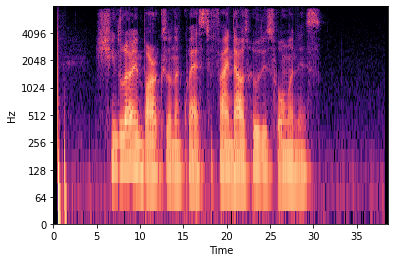

In [53]:
cleanAudioFE = FeatureExtractor(cleanAudio, windowLength = windowLength,
                                overlap = overlap,
                                sample_rate = fs)

clean_stft_features = cleanAudioFE.get_stft_spectrogram()
clean_stft_features = np.abs(clean_stft_features)

### Display STFT output
db = librosa.amplitude_to_db(clean_stft_features,ref=np.max)
librosa.display.specshow(db, sr=fs, y_axis='log', x_axis='time')

## Adding Clean audio and Noisy audio

In [54]:
noisyAudio = add_noise_to_clean_audio(cleanAudio,noiseAudio)
ipd.Audio(data = noisyAudio,rate = fs)

## Noisy Audio spectrogram

noisy phase shape: (129, 1207)


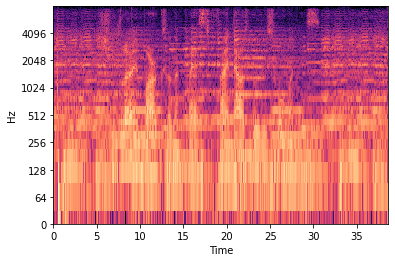

In [63]:
noisyAudioFE = FeatureExtractor(noisyAudio,windowLength = windowLength,
                                overlap = overlap,
                                sample_rate = fs)
noisy_stft_features = noisyAudioFE.get_stft_spectrogram()

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to 
# perform inverse STFT and recover human speech

noisyPhase = np.angle(noisy_stft_features)
print("noisy phase shape:",noisyPhase.shape)
noisy_stft_features = np.abs(noisy_stft_features)

mean = np.mean(noisy_stft_features)
std = np.std(noisy_stft_features)
#noisy_stft_features = (noisy_stft_features - mean) / std

### Display STFT output
db = librosa.amplitude_to_db(noisy_stft_features,ref=np.max)
librosa.display.specshow(db, sr=fs, y_axis='log', x_axis='time')

In [64]:
predictors = prepare_input_features(noisy_stft_features,
                                    numSegments = numSegments,
                                    numFeatures = numFeatures
                                   )

In [65]:
predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
predictors = np.transpose(predictors,(3,0,1,2)).astype(np.float32)
print('predictors shape:',predictors.shape)

predictors shape: (1207, 129, 8, 1)


In [66]:
STFTFullyConvolutional = model.predict(predictors)
print(STFTFullyConvolutional.shape)

(1207, 129, 1, 1)


In [67]:
denoisedAudioFC = revert_features_to_audio(features = STFTFullyConvolutional,
                                           phase = noisyPhase,
                                           window_length = windowLength,
                                           overlap = overlap,
                                           cleanMean = mean,
                                           cleanStd = std)
ipd.Audio(data = denoisedAudioFC, rate = fs)

Text(0.5, 1.0, 'Denoised Audio')

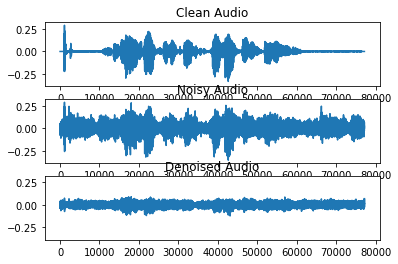

In [68]:


f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)

ax1.plot(cleanAudio)
ax1.set_title("Clean Audio")

ax2.plot(noisyAudio)
ax2.set_title("Noisy Audio")

ax3.plot(denoisedAudioFC)
ax3.set_title("Denoised Audio")

